## Sampling house prices in loncations around London
I've extended the functionality of the native RightMove API in rm.py module.  
This notebook uses the rm.py module and was run every few weeks for some months. Its results and their trend over time were summarised in: 
https://docs.google.com/spreadsheets/d/1BQklfVOCglSxPbVVkRDJ38_WxOHriGkgNkjU9gB8McY/edit?usp=sharing

In [1]:
import rm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2

### Defining inputs
Add a collection of train station names, corresponding to a static dictionary 
inside the rm.py module. If you want to extend the list of location choices, 
you'll have to use rightmove.com and pick up the codes they use for each location
from the url created, then enrich the rm.py location dictionary with that code ... 
No way around this. 

Also, defining the type of house we are after: 3 bedroom, within 1 mile from the station, a price range, type of property, etc. 

In [2]:
locations = ['st albans station',
             'harpenden station',
             #'thames ditton station' ,
             'west dulwich station' , 
             'crystal palace station', 
             'norbiton station' ,
             'surbiton station', 
             'sevenoaks station' , 
             'stevenage station' ,
             'mottingham station', 
             'chislehurst station', 
             'sidcup station', 
             'new eltham station',
             'lee station',
             ]
search_dict = {'locationIdentifier': 'sevenoaks station',
               'minBedrooms' : 3,
               'maxBedrooms' : 3,
               'propertyTypes': 'semi-detached',
               'primaryDisplayPropertyType':'houses',
                # 'propertyTypes': 'detached%2Csemi-detached%2Cterraced',
               'minPrice': 300000,
               'maxPrice': 950000,
               'radius': 1.0,
               'apiApplication': 'IPAD',
                }

### cleaning and aggregating the data
output table lists the number of houses on the market for each location and some statistics on the prices

In [3]:
results = {}
gdf = pd.DataFrame()
for my_loc in locations: 
    search_dict['locationIdentifier'] = my_loc
    my_search = rm.rm(None)
    my_search.clear_df()
    my_search.set_search_details(search_dict)
    my_search.run_search()
    results[my_loc] = my_search.df
    gdf = gdf.append(my_search.df)

gdf['place'] = gdf['searched_location'].str.split(',').str[0].str.replace(' Station','')
gdf['ad'] = gdf.autoEmailReasonType
gdf['prop'] = gdf.propertyType
gdf['loc'] = gdf.place 

sorter = gdf.place.unique()
gdf.place = gdf.place.astype("category")
gdf.place.cat.set_categories(sorter, inplace=True)

pd.options.display.float_format = '{:,.0f}'.format
gdf.groupby('place').price.describe().sort_values('place')


,count,mean,std,min,25%,50%,75%,max
place,,,,,,,,
St. Albans,56,"649,998","115,050","465,000","575,000","625,000","725,000","900,000"
Harpenden,18,"563,333","120,465","450,000","475,000","530,000","590,000","895,000"
West Dulwich,9,"665,556","74,096","550,000","650,000","650,000","715,000","775,000"
Crystal Palace,21,"546,905","138,225","360,000","465,000","520,000","575,000","950,000"
Norbiton,76,"682,495","137,321","410,000","575,000","699,975","775,000","950,000"
Surbiton,78,"685,118","123,250","479,950","596,250","675,000","778,750","950,000"
Sevenoaks,21,"561,379","123,581","395,000","485,000","540,000","635,000","860,000"
Stevenage,12,"400,000","95,299","315,000","325,000","375,000","428,750","645,000"
Mottingham,66,"471,151","97,340","300,000","399,995","475,000","550,000","750,000"


#### Let's see how the prices are distributed in a particular location

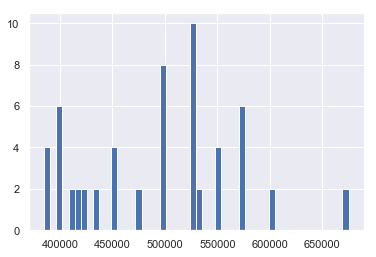

In [4]:
gdf[gdf.place == 'New Eltham'].price.hist(bins = 50)

#### How many days have these houses been on the market for? 

In [5]:
gdf.groupby('place').days_since_post.describe().sort_values('place')

,count,mean,std,min,25%,50%,75%,max
place,,,,,,,,
St. Albans,56,70,59,13,28,54,79,249
Harpenden,18,101,116,24,31,44,82,366
West Dulwich,9,143,144,21,67,96,178,497
Crystal Palace,21,64,33,24,39,61,77,152
Norbiton,76,66,48,13,34,41,91,168
Surbiton,78,111,83,20,36,115,154,313
Sevenoaks,21,124,103,7,62,87,151,354
Stevenage,12,107,110,25,38,66,130,418
Mottingham,66,77,79,17,28,41,75,331


#### Let's separate now by location and by 'new/reduced' feature. 
I am interested in locations where the price is reasonable and have a low proportion of reduced / new. 

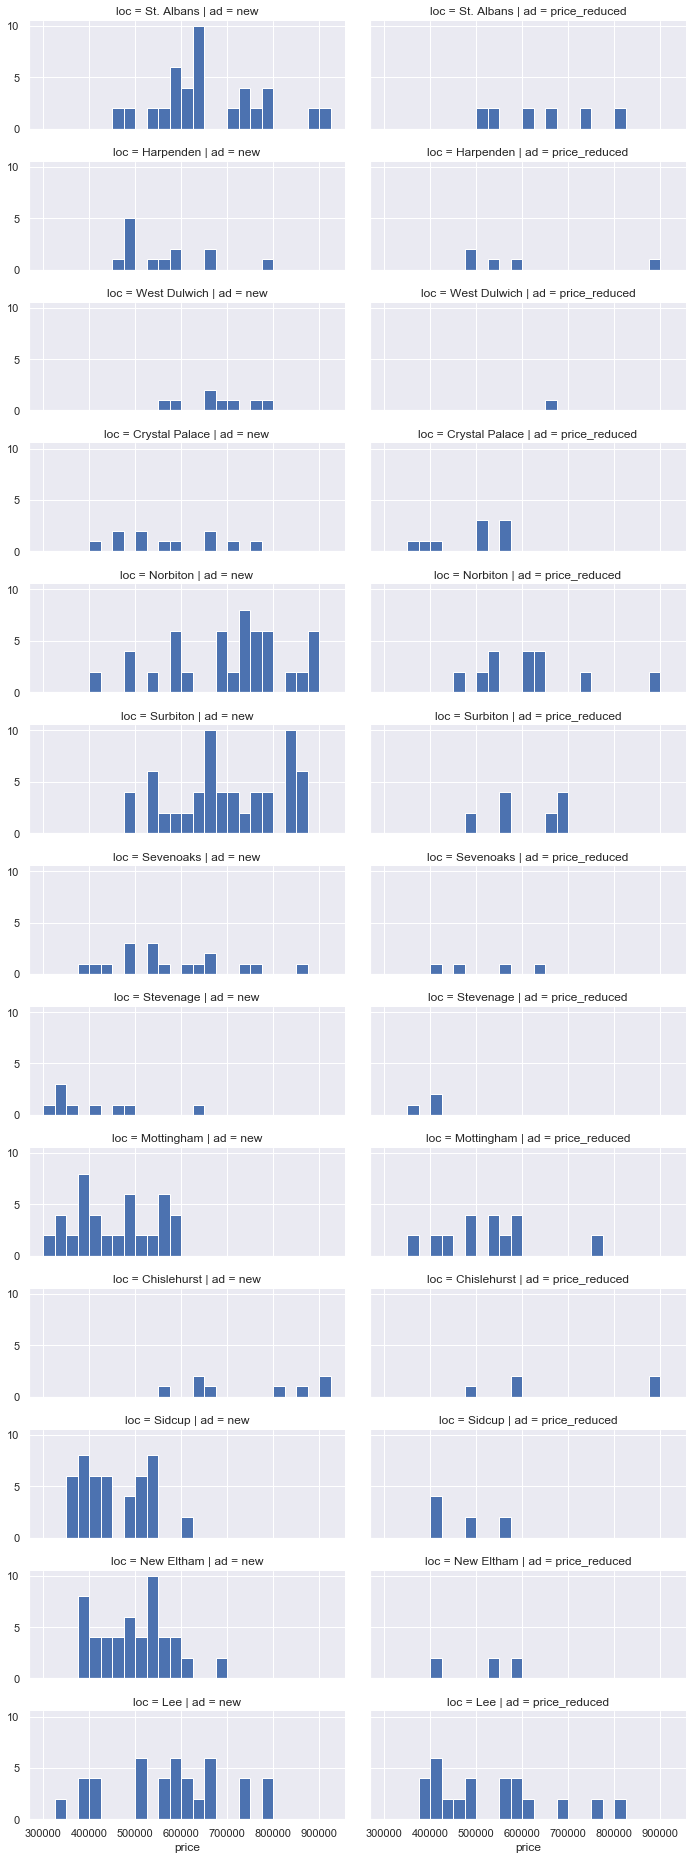

In [6]:
sns.set(font_scale=1)
bins = np.arange(search_dict['minPrice'], search_dict['maxPrice'], 25000)
g = sns.FacetGrid(gdf, row="loc",col = 'ad', height = 2, aspect = 2.5)
g.map(plt.hist, "price", bins = bins);

#### Does the number of days since posting correlate with reduced/new? How does that look by location? 

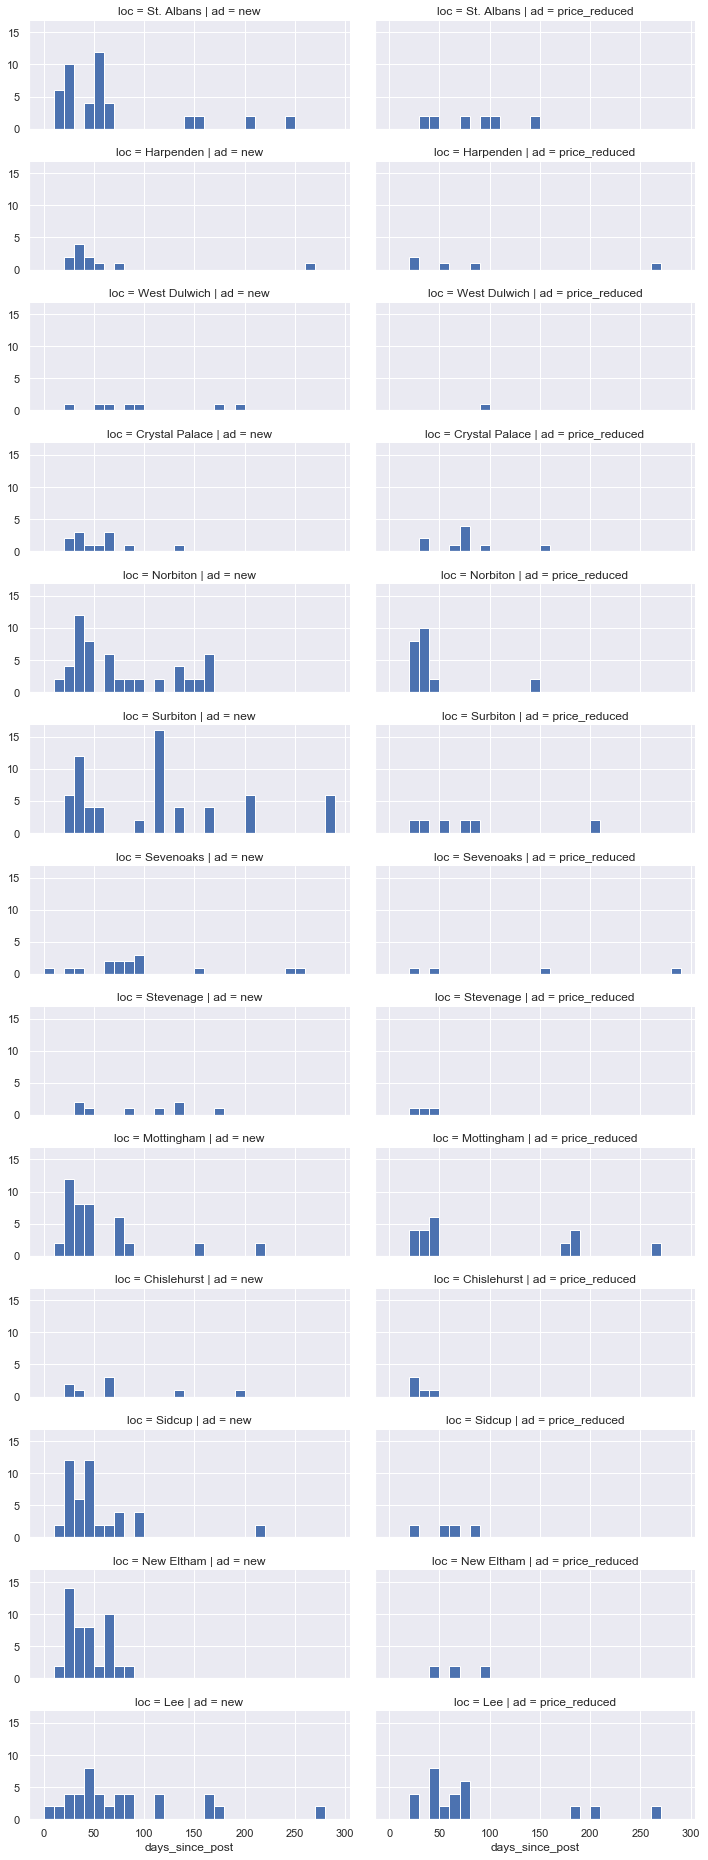

In [7]:
sns.set(font_scale=1)
bins = np.arange(0, 300, 10)
g = sns.FacetGrid(gdf, row="loc",col = 'ad', height = 2, aspect = 2.5)
g.map(plt.hist, "days_since_post", bins = bins);

### How about the type of house? ( terraced / semi-dettached / dettached ) 
Not sufficient stats by location unfortunately ... 

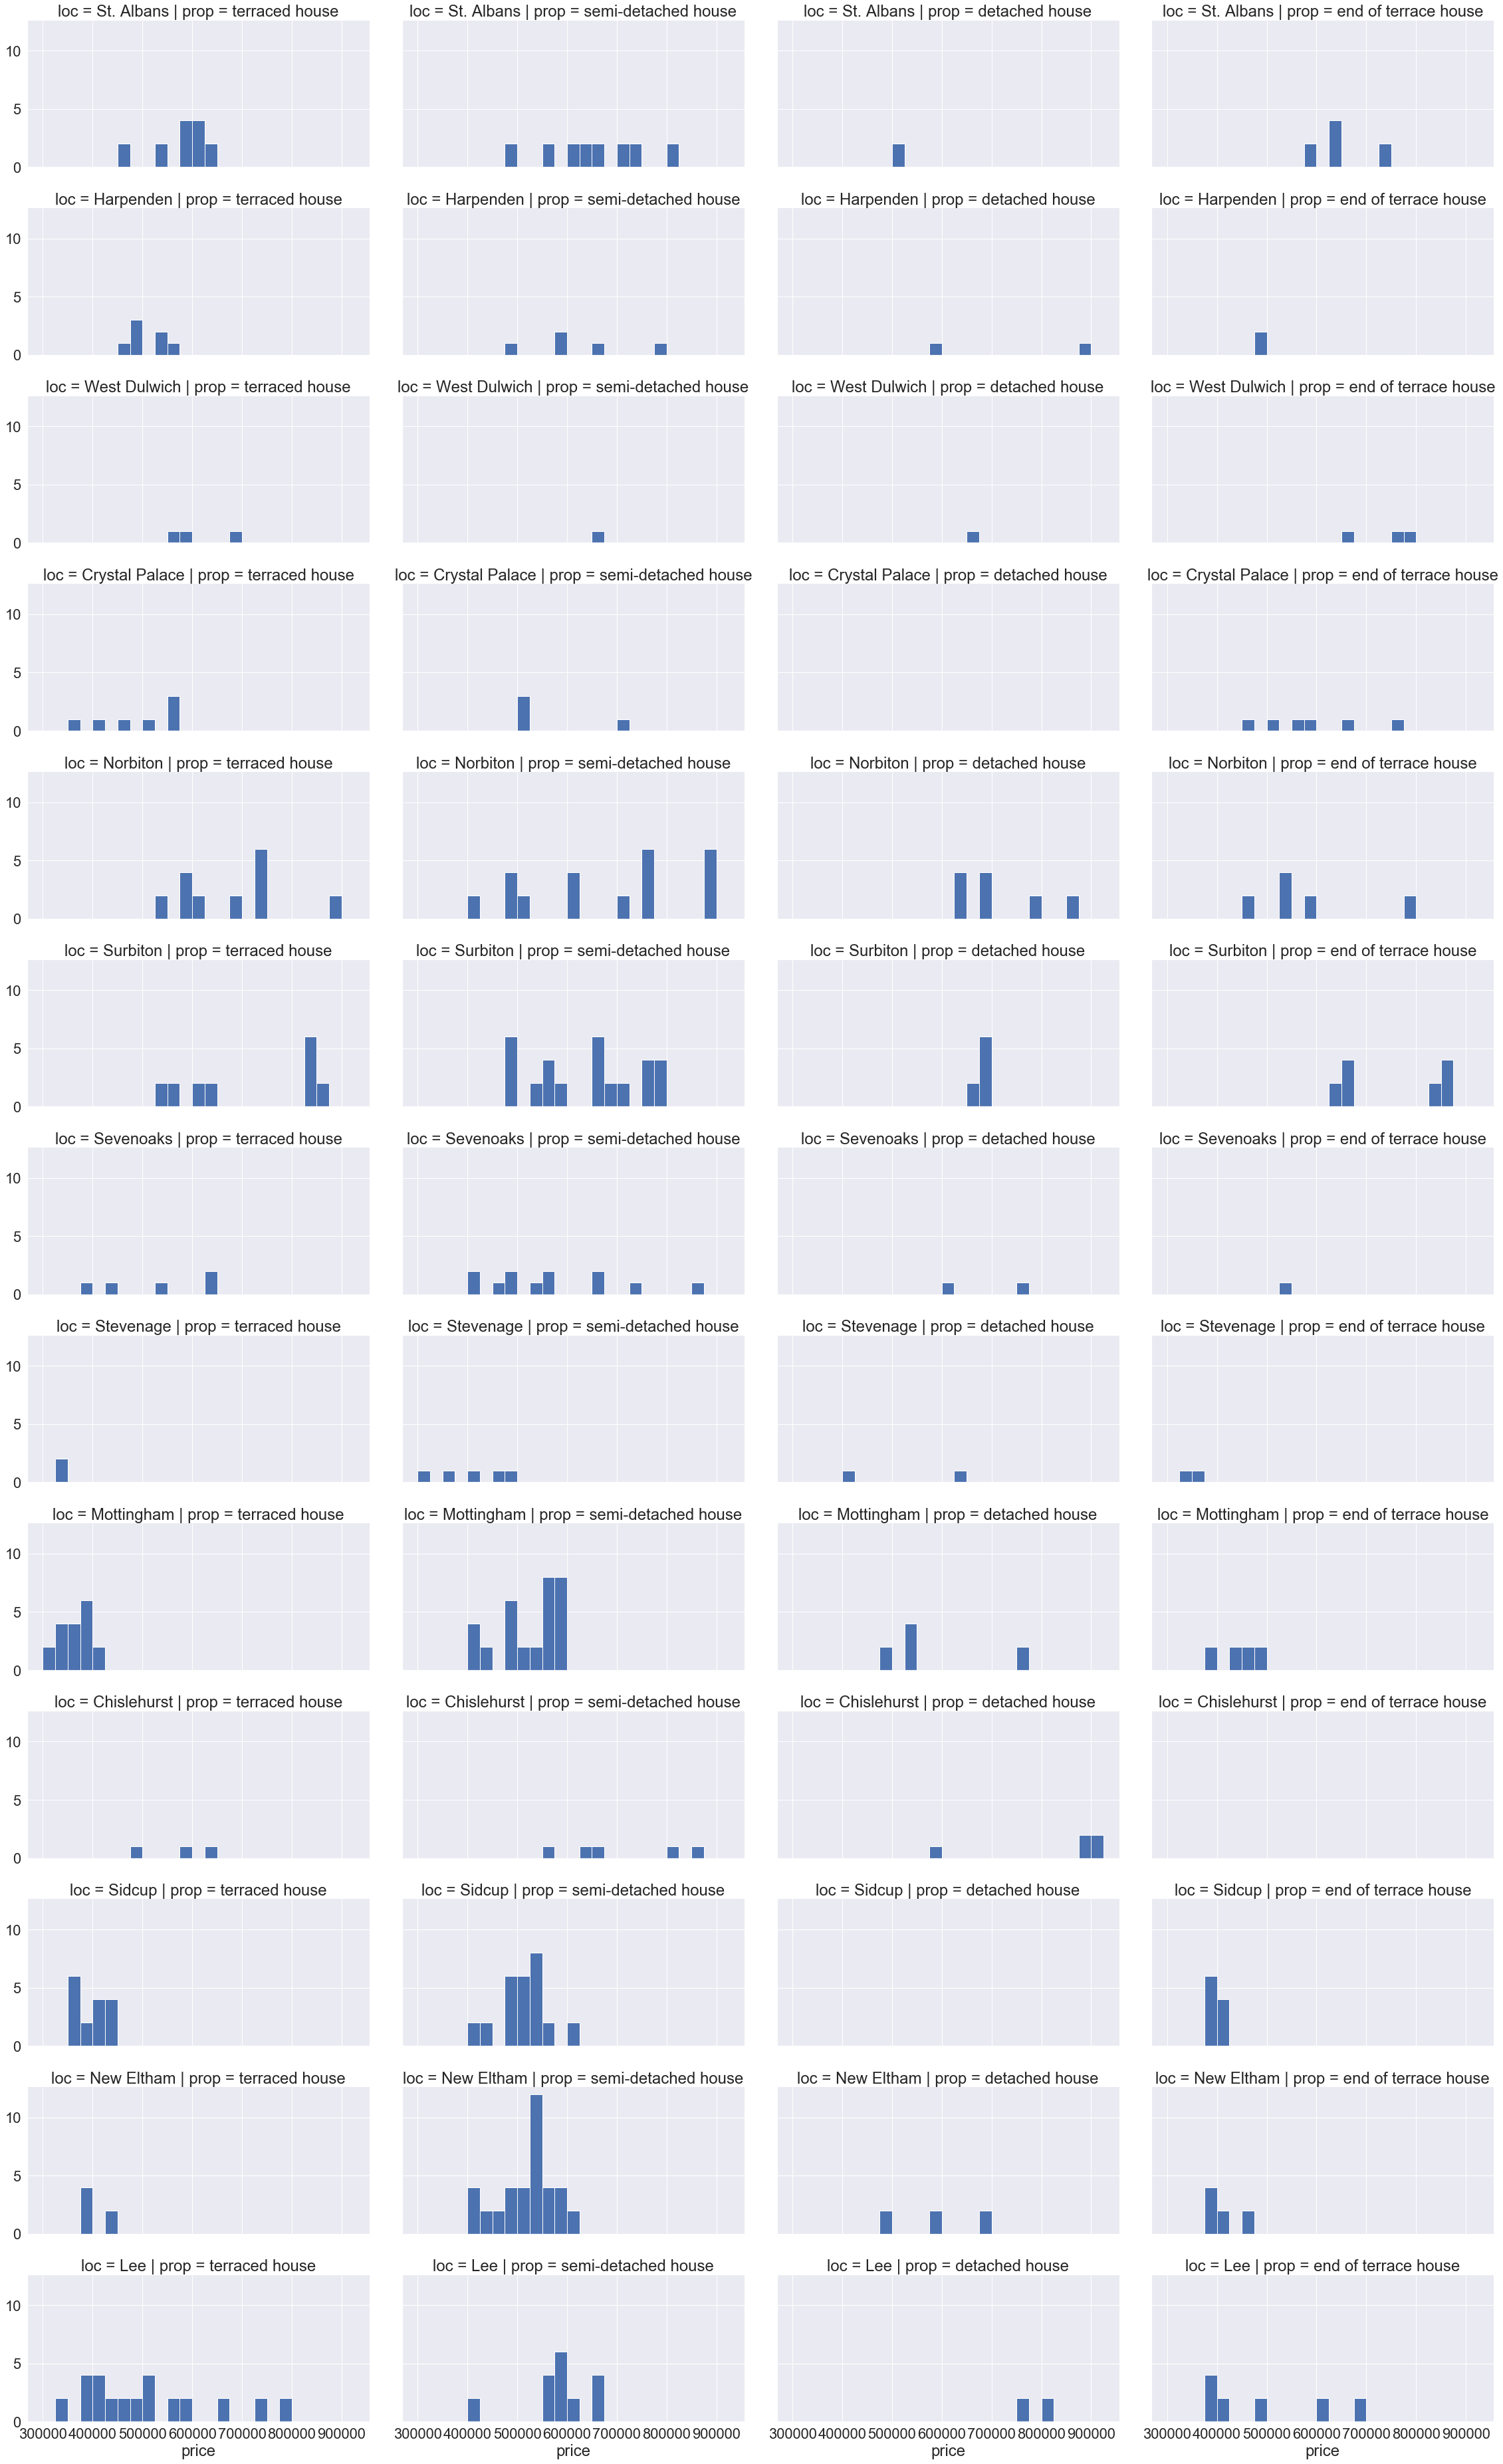

In [8]:
gdf.propertyType.value_counts()
house_type = ['terraced house', 'semi-detached house','end of terrace house','detached house']

sns.set(font_scale=2)
bins = np.arange(search_dict['minPrice'], search_dict['maxPrice'], 25000)
g = sns.FacetGrid(gdf[gdf.propertyType.isin(house_type)], row="loc",col = 'prop', height = 4, aspect = 2)
g.map(plt.hist, "price", bins = bins);
